csv file : https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data

## Import deps

In [ ]:
!pip install tensorflow pandas matplotlib sklearn

In [1]:
import os 
import pandas as pd 
import tensorflow as tf
import numpy as np

bringing data

In [2]:
df=pd.read_csv(
                os.path.join('jigsaw-toxic-comment-classification-challenge','train.csv','train.csv')
                )

In [3]:
df[df['toxic']==1].head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0


In [15]:
df.iloc[6]['comment_text']

'COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK'

## Preprocess da data 

In [4]:
from tensorflow.keras.layers import TextVectorization #for tokenization

In [18]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [5]:
# split data into comments and features
x=df['comment_text']
y=df[df.columns[2:]].values

In [6]:
MAX_WORDS=200000 #no of words in the vocab

In [24]:
# init TextVectorization layer
vectorizer=TextVectorization(max_tokens=MAX_WORDS,
                             output_sequence_length=1800,
                             output_mode='int')

In [24]:
type(x.values)

numpy.ndarray

In [25]:
# teach the verctorizer our vocab
vectorizer.adapt(x.values)

In [27]:
verctorizer('This is a sentence') #we do this for all sentences

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([14,  9,  6, ...,  0,  0,  0], dtype=int64)>

In [9]:
vectorized_text=verctorizer(x.values)

In [29]:
vectorized_text
# the rest of the sentences are 0s if they are incomplete

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]], dtype=int64)>

In [30]:
len(x) #same length

159571

In [11]:
# creating tf pipeline
dataset=tf.data.Dataset.from_tensor_slices((vectorized_text,y)) # map
dataset=dataset.cache()                                         
dataset=dataset.shuffle(160000)
dataset=dataset.batch(16)
dataset=dataset.prefetch(8)  #bottleneck prevention

In [12]:
# getting one bacth and unpack it
# ie: dataset creation
batch_x,batch_y=dataset.as_numpy_iterator().next()

In [13]:
# creating partitions
train=dataset.take(int(len(dataset)*.7)) # we will use 70% of our dataset
val=dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2)) #20
test=dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1)) #10

In [14]:
train_generator=train.as_numpy_iterator()

In [42]:
train_generator.next()

(array([[90692, 82658,   405, ...,     0,     0,     0],
        [  312,    12,   102, ...,     0,     0,     0],
        [  459,     8,    55, ...,     0,     0,     0],
        ...,
        [91134,     2,    24, ...,     0,     0,     0],
        [97049,  8629,   425, ...,     0,     0,     0],
        [  288,     7,   424, ...,     0,     0,     0]], dtype=int64),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]], dtype=int64))

## Make the seq model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dropout,Bidirectional,Embedding,Dense

In [16]:
# our NN will learn in this embedding
model=Sequential()
model.add(Embedding(MAX_WORDS+1,32)) #creating embed layer
model.add(Bidirectional(LSTM(32,activation='tanh'))) #tanh: for gpu acc, alse for like : "I dont hate you" type sentences - pass info both ways
model.add(Dense(128,activation='relu'))  # feature extractor
model.add(Dense(256,activation='relu'))  # feature extractor
model.add(Dense(128,activation='relu'))  # feature extractor
model.add(Dense(6,activation='sigmoid')) # val betn 0 & 1 only

In [17]:
model.compile(loss='BinaryCrossentropy',optimizer='Adam') #as the com can be 0 and 1 , not multi class

In [52]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 32)          6400032   
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 256)               33024     
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dense_11 (Dense)            (None, 6)                 774       
                                                      

In [20]:
# train the model for 4 or 5 or 10 epochs
history=model.fit(train,epochs=4,validation_data=val)

6981/6981 [==============================] - 6385s 915ms/step - loss: 0.0508 - val_loss: 0.0419


In [21]:
from matplotlib import pyplot as plt  

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 800x500 with 0 Axes>

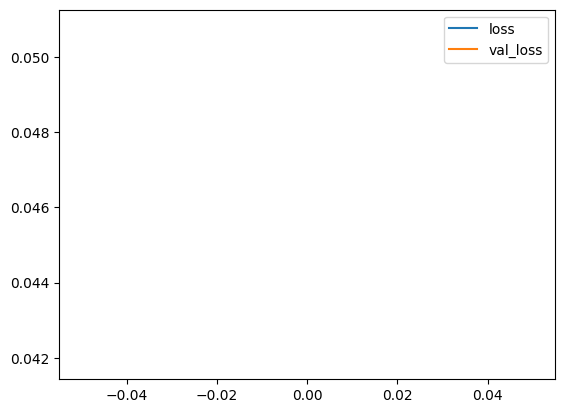

In [22]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show

## Make our predictions

In [27]:
batch=test.as_numpy_iterator().next()

In [43]:
batch_x,batch_y=test.as_numpy_iterator().next()

In [48]:
# before prediction , tokemnize the data 
# Example
input_text=vectorizer('I fucking hate you nigger ! I am coming to kill you')

In [38]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [40]:
model.predict(np.expand_dims(input_text,0))
# above 0.5(our threshold),it will be considered as true for toxic

1/1 [==============================] - 0s 53ms/step


array([[3.2237213e-02, 5.5001405e-05, 1.0287233e-02, 1.5057450e-03,
        7.9799844e-03, 5.3781052e-03]], dtype=float32)

In [42]:
model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 0s 52ms/step


array([[0.99963063, 0.28665623, 0.9902162 , 0.01043422, 0.8746136 ,
        0.18079132]], dtype=float32)

In [49]:
(model.predict(batch_x) >0.5).astype(int)

1/1 [==============================] - 0s 92ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [29]:
res=model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 1s 562ms/step


## Evaluating the model

In [50]:
from tensorflow.keras.metrics import Precision,Recall,CategoricalAccuracy

In [51]:
pre=Precision()
re=Recall()
acc=CategoricalAccuracy()

In [52]:
# make our predictions
for batch in test.as_numpy_iterator():
#     unpack the batch
    x_true,y_true=batch
#     predict
    yhat=model.predict(x_true)
    
    y_true=y_true.flatten()
    yhat=yhat.flatten()
    
    pre.update_state(y_true,yhat)
    re.update_state(y_true,yhat)
    acc.update_state(y_true,yhat)

1/1 [==============================] - 0s 112ms/step


In [53]:
# viz the results
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.834931492805481, Recall: 0.6829131841659546, Accuracy: 0.5035105347633362


In [60]:
# save the model
model.save('toxic.h5')

In [61]:
# load our tf model
model=tf.keras.models.load_model('toxic.h5')

## Test and integrating gradio
link :https://gradio.app/quickstart/

In [55]:
import gradio as gr

In [62]:
# load 
model=tf.keras.models.load_model('toxic.h5')

In [83]:
# test da model
input_str=vectorizer('I love you')

In [84]:
res=model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 0s 54ms/step


In [80]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [85]:
res>0.5

array([[False, False, False, False, False, False]])

In [86]:
res

array([[3.4730654e-02, 5.0042068e-05, 9.9567510e-03, 1.3755542e-03,
        7.8176940e-03, 4.9933069e-03]], dtype=float32)

In [88]:
# a reusable function for the gradio model
def score_comment(comment):
    vectorized_comment=verctorizer([comment])
    results=model.predict(vectorized_comment)
    
    text=''
    for i,col in enumerate(df.columns[2:]):
        text+='{}:{}\n'.format(col,results[0][i]>0.5)
        
    return text

In [91]:
interface=gr.Interface(fn=score_comment,
                      inputs=gr.inputs.Textbox(lines=2,placeholder='Chechk if you are toxic'),
                    outputs='text')

In [92]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app


1/1 [==============================] - 0s 137ms/step
